We need to change the action taken on each nodes. We are currently blocking all incoming actors. This is not a realistic actors movements on a network.

In [1]:
import sys
sys.path.append('../src/')
from random_graph import RandGraph
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
g = RandGraph()

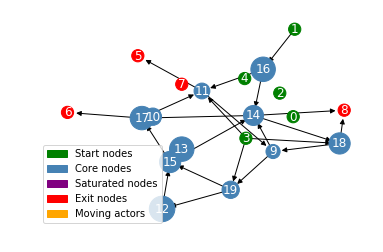

In [3]:
g.plot()

## `pass_trough`property

We need to define a new property of edges (intersection of roads) that will be used to move the number of actors from one node connected to another.

In [4]:
edges = [
    (0,1,{'pass_through':1}),
    (0,2,{'pass_through': 2}),
    (2,3,{'pass_through': 1}),
    (0,4,{'pass_through': 4})
]

In [5]:
h = nx.DiGraph()

In [6]:
h.add_edges_from(edges)

In [7]:
h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1}), (0, 2, {'pass_through': 2}), (0, 4, {'pass_through': 4}), (2, 3, {'pass_through': 1})])

This property cannot be less than 1. The sum of all output edges from one node is constant.

One action on one edge (intersection) will consist in increasing or decreasing traffic by a bounded percentage.

In [8]:
val = 0.5
edge = (0,1)
origin, dest = edge
max_capa = np.sum([x[2]['pass_through'] for x in h.edges(0, data=True)])
max_capa

7

if we increase or decrease on edge capa, we should substract or add the same cap to the max_capa.
The delta between max_capa and the sum of the rest of the edges will be distributed according to the relative capa of each edges.

In [9]:
remaining = []
below_threshold = False

for n1,n2 in h.edges(origin):
    if n2 == dest:
        increase_val = np.round(h.edges[n1,n2]['pass_through']*val, decimals=2)
        if (h.edges[n1,n2]['pass_through'] + increase_val) > 1:
            h.edges[n1,n2]['pass_through'] += increase_val
        else:
            below_threshold =True
    else:
        remaining.append(h.edges[n1,n2]['pass_through'])

sum_remain = np.sum(remaining)

# Now we should distribute delta proportionally
# pass_though * delta / sum(pass_through)
left_over = 0
for n1,n2 in h.edges(origin):
    
    if (n2 != dest) and not below_threshold:
        change = np.round((h.edges[n1,n2]['pass_through'] * increase_val) / max_capa , decimals=2) + left_over
        if (change+1) < (h.edges[n1,n2]['pass_through']):
            h.edges[n1,n2]['pass_through'] -= change
        else:
            left_over = change

In [10]:
h.edges(origin, data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1.5}), (0, 2, {'pass_through': 1.8599999999999999}), (0, 4, {'pass_through': 3.71})])

In [11]:
max_capa = np.sum([x[2]['pass_through'] for x in h.edges(0, data=True)])
max_capa

7.07

In [50]:
# vectorize
edges = [
    (0,1,{'pass_through':1}),
    (0,2,{'pass_through': 2}),
    (2,3,{'pass_through': 1}),
    (0,4,{'pass_through': 4})
]
h = nx.DiGraph()
h.add_edges_from(edges)
h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1}), (0, 2, {'pass_through': 2}), (0, 4, {'pass_through': 4}), (2, 3, {'pass_through': 1})])

In [13]:
pt_vals = []
i = 0
val = 0.5
edge = (0,1)
origin, dest = edge
for n1,n2 in h.edges(origin):
    pt_vals.append(h.edges[n1,n2]['pass_through'])
    if n2 == dest:
        idx = i
    i += 1

In [41]:
def get_pass_through_values(h, edge):
    pt_vals = []
    i = 0

    origin, dest = edge
    for n1,n2 in h.edges(origin):
        pt_vals.append(h.edges[n1,n2]['pass_through'])
        if n2 == dest:
            idx = i
        i += 1
    return pt_vals, idx

In [47]:
def set_pass_through_values(h, pt_vals, node):
    i = 0
    for n1, n2 in h.edges(node):
        h.edges[n1,n2]['pass_through'] = pt_vals[i]
        i += 1
    return h

In [37]:
get_pass_through_values((0,1))

[1, 2, 4]

In [14]:
pt_vals

[1, 2, 4]

In [15]:
idx

0

In [16]:
pt_vals = np.array(pt_vals)

In [17]:
pt_vals

array([1, 2, 4])

In [18]:
a = np.round(2/6 * 0.5, decimals=2)

In [19]:
b = np.round(4/6 * 0.5, decimals=2)

In [20]:
a + b

0.5

In [21]:
mask = np.ones_like(pt_vals)
mask[idx] = 0

In [22]:
mask

array([0, 1, 1])

In [23]:
inv_mask = np.array(mask == False, dtype=int)

In [24]:
inv_mask

array([1, 0, 0])

In [32]:
percent = 0.5

In [33]:
(pt_vals * inv_mask * percent + pt_vals*inv_mask) + ( pt_vals*mask - pt_vals*mask / np.sum(pt_vals * mask) * percent )

array([0.5       , 2.16666667, 4.33333333])

In [350]:
def update(pass_through, idx, value):
    # vector of pass_through values
    pt_vals = np.array(pass_through)
    # mask
    mask = np.ones_like(pt_vals)
    mask[idx] = 0
    # inverted mask
    inv_mask = np.array(mask == False, dtype=int)
    # value update at index
    updated_idx = pt_vals * inv_mask * value + pt_vals * inv_mask
    updated_remaining = pt_vals * mask - pt_vals * mask / np.sum(pt_vals * mask) * value
    if (np.sum(updated_idx) >= 1) & ((updated_remaining - mask) >= np.zeros_like(mask)).all():
        return updated_idx + updated_remaining
    else:
        return pt_vals

In [42]:
def action(graph, edge, value):
    origin, dest = edge
    pt_vals, idx = get_pass_through_values(graph, edge)
    updated_vals = update(pt_vals, idx, value)
    updated_graph = set_pass_through_values(graph, updated_vals, origin)
    return updated_graph

In [83]:
up_h = action(h.copy(), (0,1), -0.3)

In [84]:
up_h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 0.7}), (0, 2, {'pass_through': 2.1}), (0, 4, {'pass_through': 4.2}), (2, 3, {'pass_through': 1})])

In [85]:
h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1}), (0, 2, {'pass_through': 2}), (0, 4, {'pass_through': 4}), (2, 3, {'pass_through': 1})])

In [86]:
j = action(h, (0,1), 0.5)

In [87]:
j.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1.5}), (0, 2, {'pass_through': 1.8333333333333333}), (0, 4, {'pass_through': 3.6666666666666665}), (2, 3, {'pass_through': 1})])

In [377]:
edges = [
    (0,1,{'pass_through':1}),
    (0,2,{'pass_through': 2}),
    (2,3,{'pass_through': 1}),
    (0,4,{'pass_through': 4})
]
h = nx.DiGraph()
h.add_edges_from(edges)
h.edges(data=True)

OutEdgeDataView([(0, 1, {'pass_through': 1}), (0, 2, {'pass_through': 2}), (0, 4, {'pass_through': 4}), (2, 3, {'pass_through': 1})])

In [378]:
origin = 0
dest = 1
pt_vals, idx = get_pass_through_values(h, (origin,dest))

In [379]:
pt_vals

[1, 2, 4]

In [104]:
up_vals = update(pt_vals, 0, 0.1)

In [105]:
up_vals

array([1.1       , 1.96666667, 3.93333333])

In [248]:
up_vals = update(up_vals, 0, -0.3)
up_vals

array([1.01019435, 1.33333333, 2.66666667])

In [249]:
np.sum(up_vals)

5.010194353592339

In [376]:
np.random.randn() * 0.5

0.1776765525823625

In [380]:
vals = []
for i in range(10000):
    v = np.random.randn() * 0.5
    pt_vals = update(pt_vals, 0, v)
    vals.append(np.sum(pt_vals))

In [381]:
pt_vals

array([1.00813142, 1.00633483, 2.01266966])

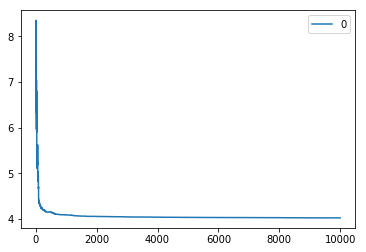

In [382]:
pd.DataFrame(vals).plot()
plt.show()